In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForImageClassification, AutoFeatureExtractor,AutoModel
from sklearn.metrics import classification_report
import numpy as np
import faiss

In [3]:
data_dir = ".\\data\\train"
data_dir = data_dir
classes = os.listdir(data_dir)
image_paths = []
labels = []
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

for cls in classes:
    cls_folder = os.path.join(data_dir, cls)
    for img_file in os.listdir(cls_folder):
        image_paths.append(os.path.join(cls_folder, img_file))
        labels.append(class_to_idx[cls])

In [4]:
from PIL import Image
import torchvision.transforms.functional as F
import torch

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.classes = os.listdir(data_dir)
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        for cls in self.classes:
            cls_folder = os.path.join(data_dir, cls)
            for img_file in os.listdir(cls_folder):
                self.image_paths.append(os.path.join(cls_folder, img_file))
                self.labels.append(self.class_to_idx[cls])

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)
        if isinstance(image, torch.Tensor) is False:
            image = F.pil_to_tensor(image)
    
        return image, label

In [5]:
from tqdm import tqdm
def extract_features(data_loader, model):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in tqdm(data_loader, desc="Extracting Features", unit="batch"):
            images = images.to(device)
            outputs = model.get_image_features(images)
            features.append(outputs.cpu().numpy())
            labels.extend(lbls.numpy())
    return np.vstack(features), np.array(labels)

In [6]:
model_name = "openai/clip-vit-base-patch32"  # Replace with specific Gemini model if available
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)  # For feature extraction, not classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\Shripad\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [8]:
data_dir = ".\\data\\train"
dataset = CustomImageDataset(data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=16, shuffle=False)

In [9]:
features, labels = extract_features(data_loader, model)

Extracting Features: 100%|████████████████████████████████████████████████████████| 166/166 [02:40<00:00,  1.03batch/s]


In [10]:
index = faiss.IndexFlatL2(features.shape[1])  
index.add(features)

### Validation 

In [13]:
def retrieve_similar_images(query_image, model, index, k=5):
    model.eval()
    with torch.no_grad():
        query_features = model.get_image_features(query_image.unsqueeze(0).to(device)).cpu().numpy()
    distances, indices = index.search(query_features, k)
    return indices, distances
def classify_image(query_image, model, index, labels, k=5):
    indices, distances = retrieve_similar_images(query_image, model, index, k)
    retrieved_labels = labels[indices[0]]
    predicted_label = np.bincount(retrieved_labels).argmax()  # Majority voting
    return predicted_label

In [16]:
# Example Usage
val_data_dir = ".\\data\\val\\"
val_dataset = CustomImageDataset(data_dir=val_data_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Evaluate the system
model.eval()
all_preds = []
all_labels = []

for images, lbls in tqdm(val_loader):
    query_image = images[0]
    true_label = lbls[0].item()
    predicted_label = classify_image(query_image, model, index, labels, k=5)

    all_preds.append(predicted_label)
    all_labels.append(true_label)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.57it/s]

              precision    recall  f1-score   support

       daisy       1.00      0.80      0.89         5
   dandelion       0.86      1.00      0.92         6
        rose       0.88      0.88      0.88         8
   sunflower       1.00      1.00      1.00         6
       tulip       0.83      0.83      0.83         6

    accuracy                           0.90        31
   macro avg       0.91      0.90      0.90        31
weighted avg       0.91      0.90      0.90        31



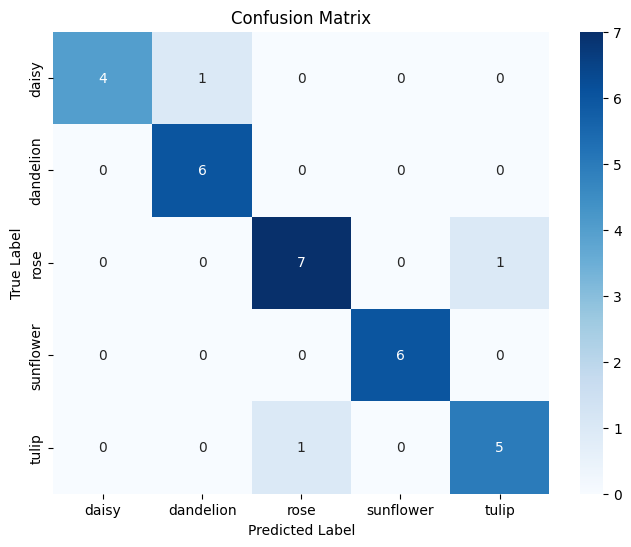

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [21]:
faiss.write_index(index, "faiss_index_flower.bin")
import json

In [22]:
faiss_index = faiss.read_index("faiss_index_flower.bin")